In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch

/home/m123/anaconda3/envs/qwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import cv2
import mat73
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector
import math

In [3]:
np.random.seed(42)

folder_dir = 'data_np/'

mat_files = sorted([file for file in os.listdir(folder_dir) if file.endswith('.npy')])
idx = 1

print(mat_files[idx])

20s_long_heating_refl_50Hz_15J_-70°C_2.npy


In [4]:
image_sequence = np.load(folder_dir + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

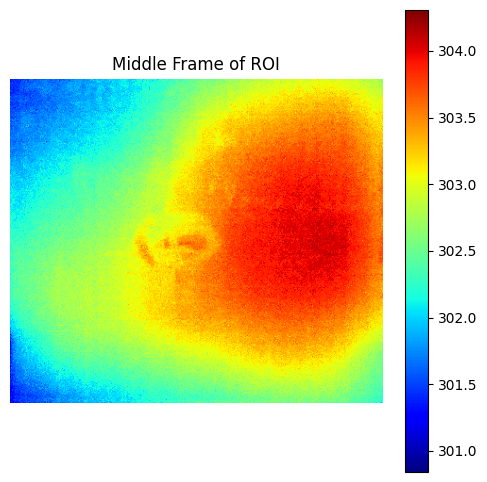

In [5]:
# y1, y2, x1, x2 = 72, 316, 159, 410
# image_sequence = image_sequence[y1:y2, x1:x2, :]

image_sequence = image_sequence[:, 100:495, :] 

h, w, t = image_sequence.shape
middle_frame = image_sequence[:, :, t // 2]
plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

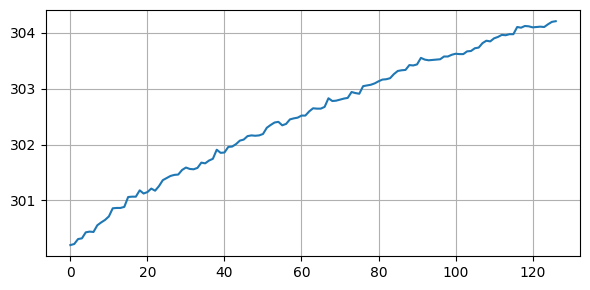

162


In [6]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,173:300])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 141

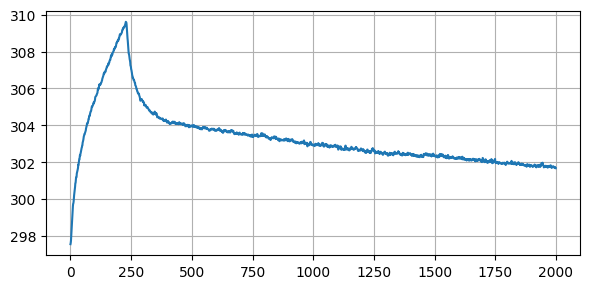

In [7]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

original_len = imageMatrix.shape[1]
target_len = 2000

x_old = np.linspace(0, 1, original_len)
x_new = np.linspace(0, 1, target_len)

f = interp1d(x_old, imageMatrix, kind="linear", axis=1)
imageMatrix = f(x_new)

plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000, :])
plt.grid(True)
plt.tight_layout()
plt.show()

imageMatrix = (imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True))

n_components = 10
latent_dim = n_components

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(imageMatrix)

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1600):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class cnn_1d_attention(nn.Module):
    def __init__(self, latent_dim, latent_size):
        super(cnn_1d_attention, self).__init__()

        # Encoding
        self.enc_conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding='same')
        self.enc_conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding='same')
        self.enc_conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Bottleneck
        self.bottleneck = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same')
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=128, nhead=8, dim_feedforward=512, batch_first=True),
                num_layers=2
            )

        # Decoding
        self.upsample1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding='same')

        self.upsample2 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding='same')

        self.upsample3 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv1d(16, 16, kernel_size=3, stride=1, padding='same')

        self.final_conv = nn.Conv1d(16, 1, kernel_size=1)

        # Positional Encoding
        self.positional_encoding_enc = PositionalEncoding(128)

        # MLP
        self.latent_len = latent_size

        self.mlp_enc = nn.Sequential(
            nn.Linear(128 * self.latent_len, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

        self.mlp_dec = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * self.latent_len)
        )


    def forward(self, x):
        # Encoder
        enc1 = F.relu(self.enc_conv1(x))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))

        bottleneck_transformer = bottleneck.permute(0, 2, 1)
        bottleneck_transformer = self.positional_encoding_enc(bottleneck_transformer)

        transformer_output = self.transformer_encoder(bottleneck_transformer)

        z_flat = transformer_output.reshape(transformer_output.size(0), -1)
        z = self.mlp_enc(z_flat)

        transformer_recon = self.mlp_dec(z)

        z_recon = transformer_recon.view(transformer_output.size(0), transformer_output.size(1), 128)

        # Decoder
        dec1 = self.upsample1(z_recon.permute(0, 2, 1))
        dec1 = F.relu(self.dec_conv1(dec1))

        dec2 = self.upsample2(dec1)
        dec2 = F.relu(self.dec_conv2(dec2))

        dec3 = self.upsample3(dec2)
        dec3 = F.relu(self.dec_conv3(dec3))

        x_recon = self.final_conv(dec3)

        return x_recon, z, transformer_output, z_recon

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
train_data = torch.tensor(imageMatrix, dtype=torch.float32)

subset_indices = torch.randperm(train_data.shape[0])[:2500]
subset_data = train_data[subset_indices]

pca_data = pca_result[subset_indices]
z_pca_all = torch.tensor(pca_data, dtype=torch.float32, device=device)

subset_data = subset_data.unsqueeze(1).to(device)

dataset = TensorDataset(subset_data, z_pca_all)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

latent_size = imageMatrix.shape[-1] // 8
model = cnn_1d_attention(latent_dim=latent_dim, latent_size=latent_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [11]:
import torch.nn.functional as F

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for x, z_pca in dataloader:
        x = x.to(device)
        z_pca = z_pca.to(device)

        optimizer.zero_grad()
        x_recon, z_ae, z, z_recon = model(x)

        loss_recon = F.mse_loss(x_recon, x)
        loss_recon_z = F.mse_loss(z_recon, z)

        loss = loss_recon + 1.0 * loss_recon_z

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

print(f"Epoch {epoch+1}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

Epoch 0: Total Loss = 3.1368 | Recon = 3.0638 | Z = 0.0730
Epoch 10: Total Loss = 0.0360 | Recon = 0.0229 | Z = 0.0131
Epoch 20: Total Loss = 0.0127 | Recon = 0.0084 | Z = 0.0043
Epoch 30: Total Loss = 0.0094 | Recon = 0.0066 | Z = 0.0028
Epoch 40: Total Loss = 0.0090 | Recon = 0.0066 | Z = 0.0023
Epoch 50: Total Loss = 0.0090 | Recon = 0.0077 | Z = 0.0013
Epoch 60: Total Loss = 0.0057 | Recon = 0.0046 | Z = 0.0011
Epoch 70: Total Loss = 0.0048 | Recon = 0.0034 | Z = 0.0014
Epoch 80: Total Loss = 0.0038 | Recon = 0.0030 | Z = 0.0008
Epoch 90: Total Loss = 0.0037 | Recon = 0.0030 | Z = 0.0007
Epoch 100: Total Loss = 0.0043 | Recon = 0.0036 | Z = 0.0007


In [12]:
batch_size = 64

dataset = TensorDataset(train_data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_latents = []

with torch.no_grad():
    for batch in loader:
        x = batch[0].to(device).unsqueeze(1)
        x_recon, z_ae, z, z_recon = model(x)
        all_latents.append(z_ae.cpu())

principal_comp = torch.cat(all_latents, dim=0).numpy()

In [13]:
pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

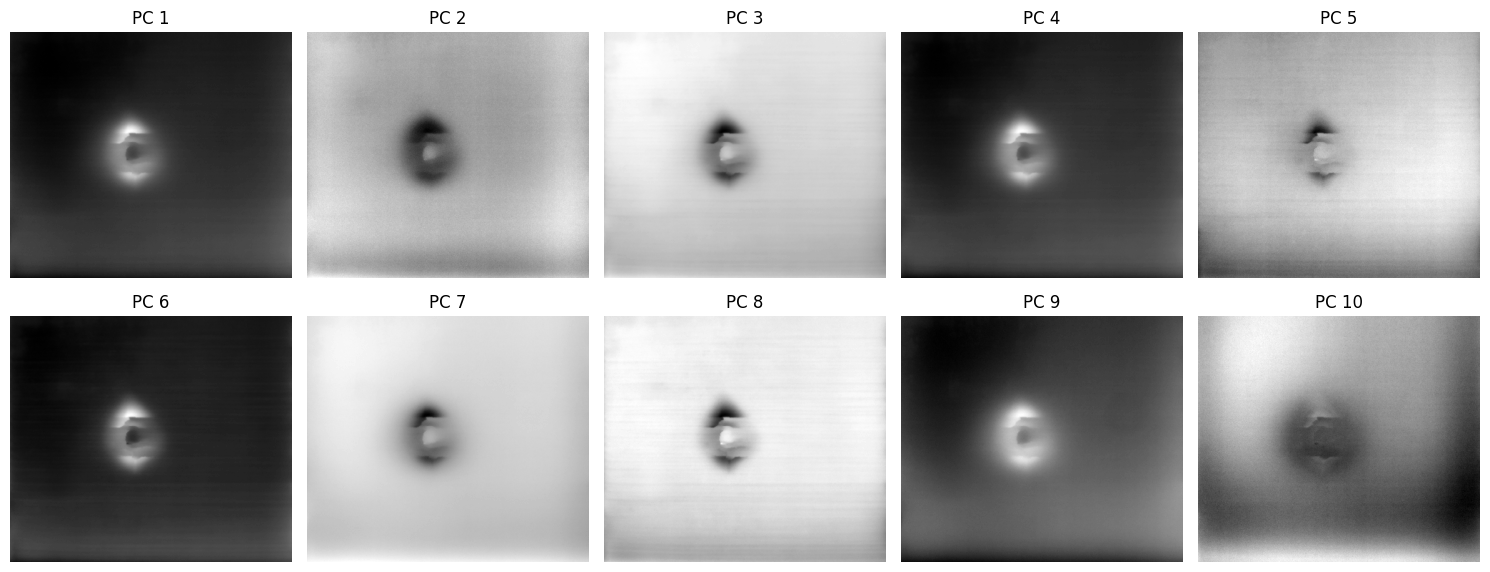

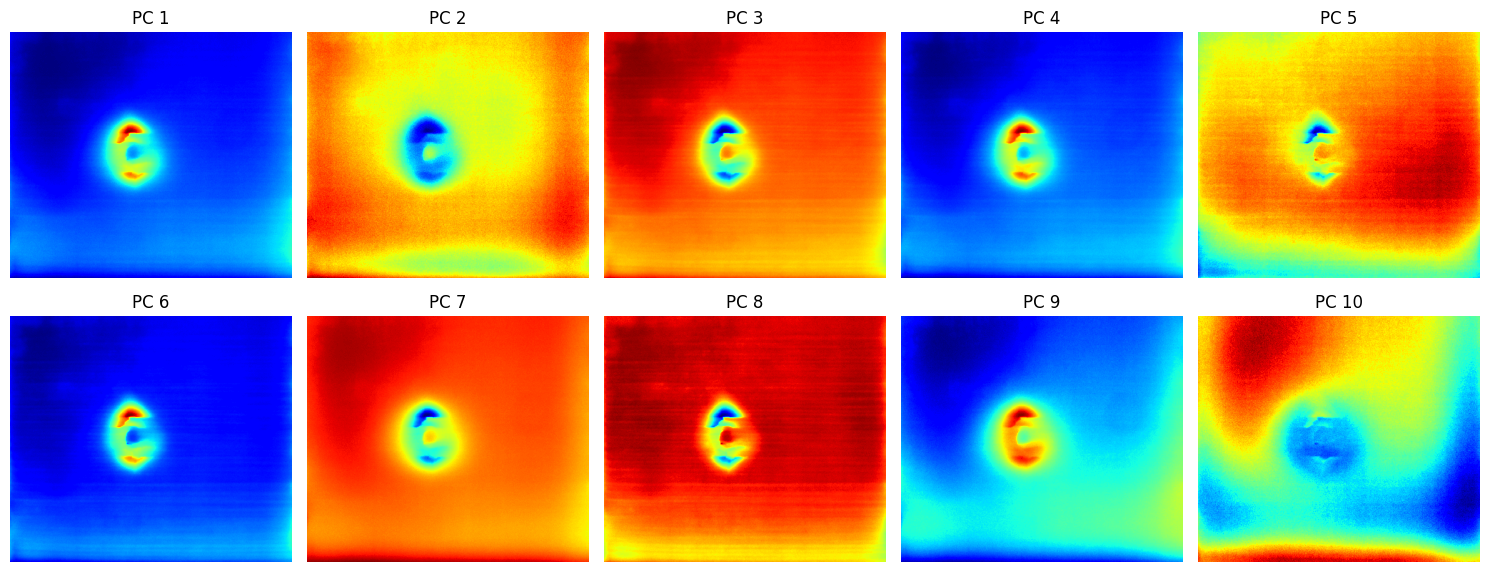

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

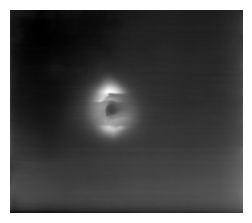

In [22]:
import torch
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

C, H, W = pca_array.shape
flat = pca_array.reshape(C, -1).T

pca = PCA(n_components=1)
pca_result = pca.fit_transform(flat)
comp = pca_result.reshape(H, W)

# comp = np.max(pca_array, axis=0)

comp -= comp.min()
comp /= comp.max()

comp = (comp * 255).astype(np.uint8)

gray_8u = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# gray_8u = clahe.apply(gray_8u)

bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
img_rgb = cv2.cvtColor(gray_8u, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(3, 3))
plt.imshow(img_rgb, cmap='gray')
plt.axis('off')
plt.show()

In [16]:
import torch
from qwen_vl_utils import process_vision_info
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor, AutoModelForCausalLM

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

Loading checkpoint shards: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [23]:
from PIL import Image, ImageDraw

image = Image.fromarray(img_rgb).convert("RGB")
W, H = image.size

save_path = "temp_image.jpg" 
image.save(save_path)

In [24]:
messages = [
    {
        "role": "system",
        "content": (
            "You are an expert NDT thermography inspection assistant.\n"
            "Your task is to detect subsurface defects in thermal images and return their exact bbox.\n"
            "Strict output rules:\n"
            "1) Output a JSON list of objects in this format: [{\"label\": \"defect\", \"box\": [x1, y1, x2, y2]}]."
            "2) Coordinates must be integers. (x1, y1) is top-left, (x2, y2) is bottom-right, and x2 > x1, y2 > y1.\n"
            "3) If multiple defects are present, return each on a new line in the same JSON format.\n"
            "4) If no defect is found, return exactly: [{\"label\": \"none\", \"box\": [0, 0, 0, 0]}]\n"
            "5) Do not include any explanation or extra text. Return only valid JSON.\n"
        )
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": f"file://{save_path}"},
            {"type": "text", "text": "Inspect the thermal image for defects. Return only the required format."}
        ]
    }
]

In [25]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [26]:
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['[{"label": "defect", "box": [148, 126, 207, 184]}]']


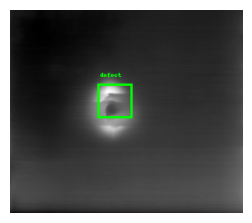

In [27]:
import json
import re
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt

raw = output_text[0]
cleaned = re.sub(r"```json|```", "", raw).strip()
boxes = json.loads(cleaned)

w, h = image.size

draw = ImageDraw.Draw(image)

for item in boxes:
    label = item["label"]
    x1, y1, x2, y2 = item["box"]

    draw.rectangle([(x1, y1), (x2, y2)], outline="lime", width=4)
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except:
        font = ImageFont.load_default()
    draw.text((x1 + 5, max(0, y1 - 20)), label, fill="lime", font=font)

plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.axis("off")
plt.show()